# 📊 하수도 인프라 지수 분석

## 📋 분석 개요

이 노트북은 한국환경공단의 하수도 보급률 데이터를 분석하여 지역별 하수도 인프라 지수를 계산하고 시각화합니다.

### 🎯 분석 목표
- 지역별 하수도 인프라 현황 파악
- 하수도 인프라 지수 개발 및 등급 분류
- 지역간 인프라 격차 분석
- 시각화를 통한 인사이트 도출

### 📊 주요 지표
- 하수도 설치율
- 공공하수처리구역 인구보급률
- 고도처리인구 보급률
- 인구 밀도

### 🏆 인프라 지수 구성
- 하수도설치율 (30%)
- 공공하수처리구역 인구보급률 (30%)
- 고도처리인구 보급률 (20%)
- 인구밀도 정규화 (20%)

In [57]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import folium
import geopandas as gpd
import json
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
import matplotlib.font_manager as fm

# 나눔고딕 폰트 경로 설정
font_path = r'/Users/sullem/yj/HIuniv_Project/data/NanumGothic.ttf'

# 폰트 등록 및 설정
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

print("폰트 설정 완료")

print("라이브러리 임포트 완료")

폰트 설정 완료
라이브러리 임포트 완료


## 📁 전처리된 데이터 로드

In [58]:
# 전처리된 데이터 로드
import os
# 현재 작업 디렉토리 확인
print(f"현재 작업 디렉토리: {os.getcwd()}")
# 절대 경로 사용
project_dir = r"/Users/sullem/yj/HIuniv_Project"
file_path = os.path.join(project_dir, "data", "processed", "sewer_infrastructure_processed.csv")
print(f"절대 경로: {file_path}")
print(f"파일 존재 여부: {os.path.exists(file_path)}")
df = pd.read_csv(file_path, encoding='utf-8')

print(f"전처리된 데이터 로드 완료: {len(df)}개 행, {len(df.columns)}개 컬럼")
print(f"컬럼명: {list(df.columns)}")
print(f"/n시도별 데이터 개수:")
print(df['시도'].value_counts())
df.head()

현재 작업 디렉토리: /Users/sullem/yj/HIuniv_Project/notebooks
절대 경로: /Users/sullem/yj/HIuniv_Project/data/processed/sewer_infrastructure_processed.csv
파일 존재 여부: True
전처리된 데이터 로드 완료: 2398개 행, 8개 컬럼
컬럼명: ['시도', '행정구역명', '총인구(명)', '총면적', '하수도설치율', '공공하수처리구역 인구보급률', '고도처리인구 보급률', '인구밀도']

시도별 데이터 개수:
시도
경기도        567
경상남도       305
전라남도       297
경상북도       291
전라북도       243
충청남도       207
강원특별자치도    193
충청북도       153
제주특별자치도     43
서울특별시       25
세종특별자치시     24
부산광역시       16
인천광역시       10
대구광역시        9
대전광역시        5
광주광역시        5
울산광역시        5
Name: count, dtype: int64


,시도,행정구역명,총인구(명),총면적,하수도설치율,공공하수처리구역 인구보급률,고도처리인구 보급률,인구밀도
0,서울특별시,종로구,150453,23.913,100.0,100.0,100.0,6291.682349
1,서울특별시,중구,131793,9.960,100.0,100.0,100.0,13232.228916
2,서울특별시,용산구,227106,21.868,100.0,100.0,100.0,10385.311871
3,서울특별시,성동구,284766,16.820,100.0,100.0,100.0,16930.202140
4,서울특별시,광진구,351180,17.063,100.0,100.0,100.0,20581.374905


## 🔍 데이터 탐색

In [59]:
# 기본 정보 확인
print("=== 데이터 기본 정보 ===")
print(df.info())

print("/n=== 기술 통계 ===")
print(df.describe())

print("/n=== 결측값 현황 ===")
print(df.isnull().sum())

=== 데이터 기본 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2398 entries, 0 to 2397
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   시도              2398 non-null   object 
 1   행정구역명           2398 non-null   object 
 2   총인구(명)          2398 non-null   int64  
 3   총면적             2398 non-null   float64
 4   하수도설치율          2398 non-null   float64
 5   공공하수처리구역 인구보급률  2398 non-null   float64
 6   고도처리인구 보급률      2398 non-null   float64
 7   인구밀도            2398 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 150.0+ KB
None

=== 기술 통계 ===
              총인구(명)          총면적       하수도설치율  공공하수처리구역 인구보급률   고도처리인구 보급률  /
count    2398.000000  2398.000000  2398.000000     2398.000000  2398.000000   
mean    21816.175980    41.888753    65.846872       78.205546    75.150083   
std     58879.339364    49.352281    31.439303       26.603280    29.316253   
min         0.000000     0

## 📊 하수도 인프라 지수 계산

In [60]:
# 가중치 설정
weights = {
    '하수도설치율': 0.3,
    '공공하수처리구역 인구보급률': 0.3,
    '고도처리인구 보급률': 0.2,
    '인구밀도_정규화': 0.2
}

# 인구 밀도 정규화 (0-100 스케일)
scaler = MinMaxScaler(feature_range=(0, 100))
df['인구밀도_정규화'] = scaler.fit_transform(df[['인구밀도']])

# 가중 평균으로 인프라 지수 계산
df['하수도_인프라_지수'] = (
    df['하수도설치율'] * weights['하수도설치율'] +
    df['공공하수처리구역 인구보급률'] * weights['공공하수처리구역 인구보급률'] +
    df['고도처리인구 보급률'] * weights['고도처리인구 보급률'] +
    df['인구밀도_정규화'] * weights['인구밀도_정규화']
)

# 지수 등급 분류
df['인프라_등급'] = pd.cut(
    df['하수도_인프라_지수'],
    bins=[0, 40, 60, 80, 100],
    labels=['매우 낮음', '낮음', '보통', '높음'],
    include_lowest=True
)

print("하수도 인프라 지수 계산 완료")
print(f"평균 인프라 지수: {df['하수도_인프라_지수'].mean():.2f}")
print(f"최고 인프라 지수: {df['하수도_인프라_지수'].max():.2f}")
print(f"최저 인프라 지수: {df['하수도_인프라_지수'].min():.2f}")

df.head()

하수도 인프라 지수 계산 완료
평균 인프라 지수: 59.87
최고 인프라 지수: 99.18
최저 인프라 지수: 0.00


,시도,행정구역명,총인구(명),총면적,하수도설치율,공공하수처리구역 인구보급률,고도처리인구 보급률,인구밀도,인구밀도_정규화,하수도_인프라_지수,인프라_등급
0,서울특별시,종로구,150453,23.913,100.0,100.0,100.0,6291.682349,13.647297,82.729459,높음
1,서울특별시,중구,131793,9.960,100.0,100.0,100.0,13232.228916,28.702046,85.740409,높음
2,서울특별시,용산구,227106,21.868,100.0,100.0,100.0,10385.311871,22.526794,84.505359,높음
3,서울특별시,성동구,284766,16.820,100.0,100.0,100.0,16930.202140,36.723325,87.344665,높음
4,서울특별시,광진구,351180,17.063,100.0,100.0,100.0,20581.374905,44.643089,88.928618,높음


## 📈 시각화

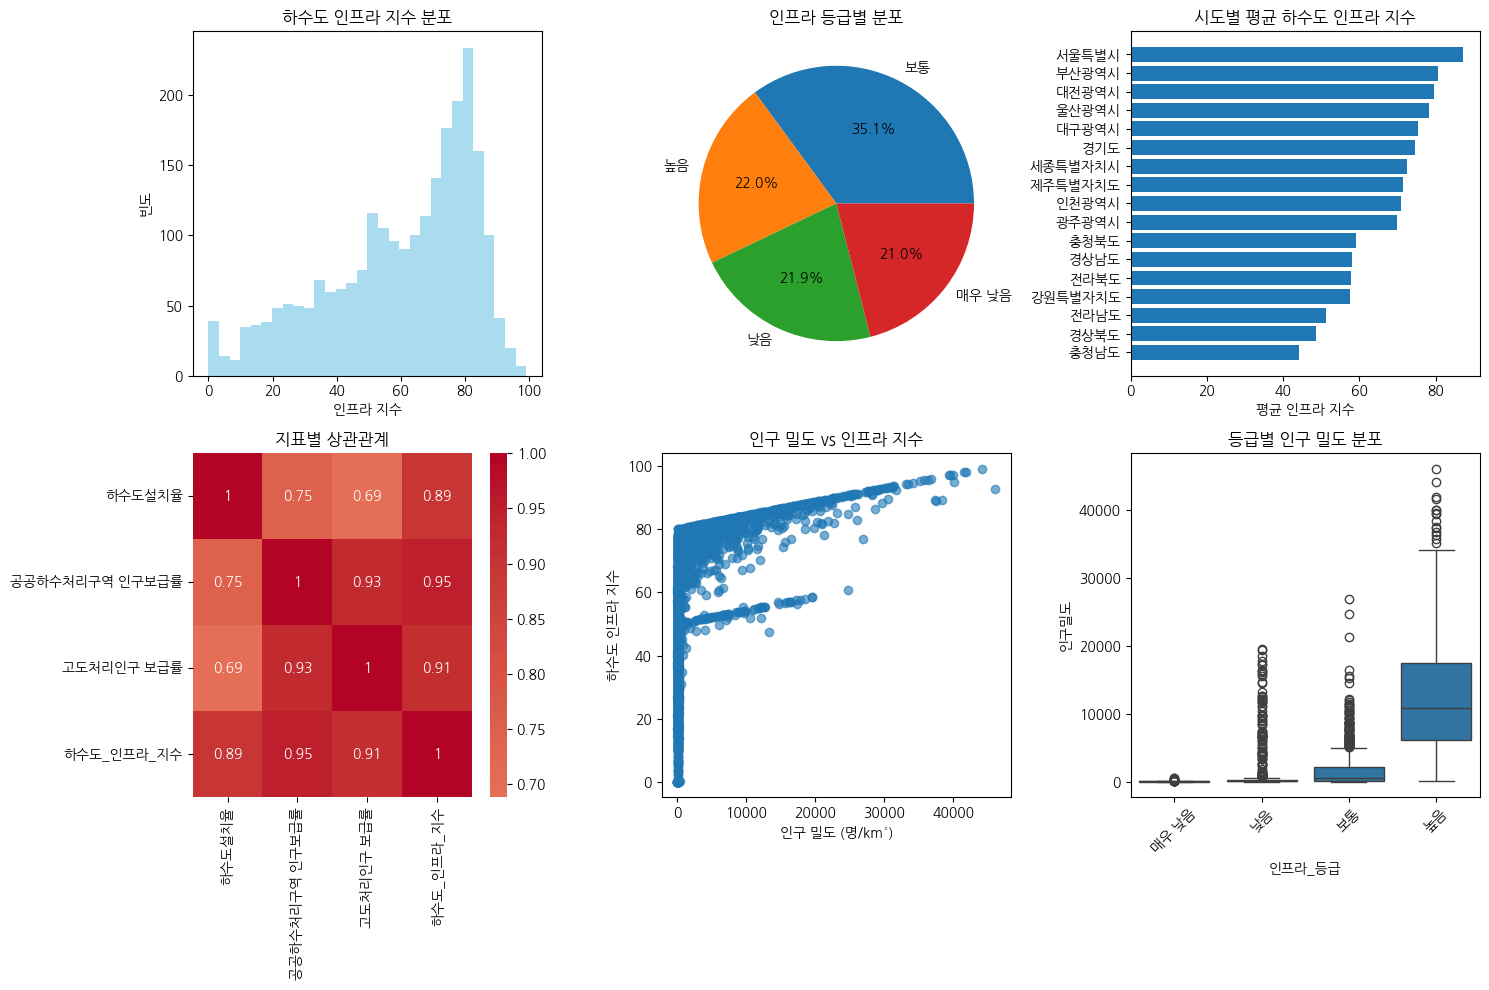

In [61]:
# 1. 인프라 지수 분포
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(df['하수도_인프라_지수'], bins=30, alpha=0.7, color='skyblue')
plt.title('하수도 인프라 지수 분포')
plt.xlabel('인프라 지수')
plt.ylabel('빈도')

# 2. 등급별 분포
plt.subplot(2, 3, 2)
grade_counts = df['인프라_등급'].value_counts()
plt.pie(grade_counts.values, labels=grade_counts.index, autopct='%1.1f%%')
plt.title('인프라 등급별 분포')

# 3. 시도별 평균 지수
plt.subplot(2, 3, 3)
region_means = df.groupby('시도')['하수도_인프라_지수'].mean().sort_values(ascending=True)
plt.barh(range(len(region_means)), region_means.values)
plt.yticks(range(len(region_means)), region_means.index)
plt.title('시도별 평균 하수도 인프라 지수')
plt.xlabel('평균 인프라 지수')

# 4. 지표별 상관관계
plt.subplot(2, 3, 4)
correlation_cols = ['하수도설치율', '공공하수처리구역 인구보급률', '고도처리인구 보급률', '하수도_인프라_지수']
correlation_matrix = df[correlation_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('지표별 상관관계')

# 5. 인구 밀도 vs 인프라 지수
plt.subplot(2, 3, 5)
plt.scatter(df['인구밀도'], df['하수도_인프라_지수'], alpha=0.6)
plt.xlabel('인구 밀도 (명/km²)')
plt.ylabel('하수도 인프라 지수')
plt.title('인구 밀도 vs 인프라 지수')

# 6. 등급별 인구 밀도 분포
plt.subplot(2, 3, 6)
sns.boxplot(data=df, x='인프라_등급', y='인구밀도')
plt.title('등급별 인구 밀도 분포')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 🏆 상위/하위 지역 분석

In [62]:
# 상위 20개 지역
top_regions = df.nlargest(20, '하수도_인프라_지수')[
    ['시도', '행정구역명', '하수도_인프라_지수', '인프라_등급', '하수도설치율', '공공하수처리구역 인구보급률']
]

print("=== 상위 20개 지역 ===")
print(top_regions)

# 하위 20개 지역
bottom_regions = df.nsmallest(20, '하수도_인프라_지수')[
    ['시도', '행정구역명', '하수도_인프라_지수', '인프라_등급', '하수도설치율', '공공하수처리구역 인구보급률']
]

print("/n=== 하위 20개 지역 ===")
print(bottom_regions)

=== 상위 20개 지역 ===
       시도  행정구역명  하수도_인프라_지수 인프라_등급  하수도설치율  공공하수처리구역 인구보급률
164   경기도   은행1동   99.176828     높음   100.0           100.0
143   경기도   신흥1동   98.174358     높음   100.0           100.0
360   경기도   일산3동   98.063966     높음   100.0           100.0
150   경기도   수진1동   97.373845     높음   100.0           100.0
373   경기도    부림동   97.187490     높음   100.0           100.0
358   경기도   일산1동   97.119215     높음   100.0           100.0
148   경기도   태평3동   95.948171     높음   100.0           100.0
261   경기도   하안3동   95.768139     높음   100.0           100.0
447   경기도   덕풍2동   95.503546     높음   100.0           100.0
257   경기도   철산3동   95.239486     높음   100.0           100.0
382   경기도   수택2동   95.048992     높음    92.7           100.0
145   경기도   신흥3동   94.816934     높음   100.0           100.0
361   경기도   탄현1동   94.520447     높음   100.0           100.0
168   경기도  상대원3동   94.396808     높음   100.0           100.0
306   경기도   본오2동   93.635712     높음   100.0           100.0
224   경기도    부흥동   93.

## 🏛️ 시도별 분석

In [63]:
# 시도별 통계
region_stats = df.groupby('시도').agg({
    '하수도_인프라_지수': ['mean', 'std', 'min', 'max', 'count'],
    '하수도설치율': 'mean',
    '공공하수처리구역 인구보급률': 'mean',
    '고도처리인구 보급률': 'mean',
    '인구밀도': 'mean'
}).round(2)

region_stats.columns = [
    '평균_인프라지수', '표준편차', '최소값', '최대값', '지역수',
    '평균_하수도설치율', '평균_공공하수처리구역', '평균_고도처리', '평균_인구밀도'
]

print("=== 시도별 하수도 인프라 통계 ===")
print(region_stats.sort_values('평균_인프라지수', ascending=False))

# 시도별 등급 분포
grade_by_region = pd.crosstab(df['시도'], df['인프라_등급'])
print("/n=== 시도별 인프라 등급 분포 ===")
print(grade_by_region)

=== 시도별 하수도 인프라 통계 ===
         평균_인프라지수   표준편차    최소값    최대값  지역수  평균_하수도설치율  평균_공공하수처리구역  평균_고도처리  /
시도                                                                             
서울특별시       87.25   2.02  82.73  90.98   25      99.94       100.00   100.00   
부산광역시       80.58   4.91  71.68  87.40   16      91.20        99.54    97.42   
대전광역시       79.60   2.09  76.36  81.45    5      97.42        98.24    98.10   
울산광역시       78.25   3.64  73.62  82.22    5      90.84        99.22    99.22   
대구광역시       75.49  13.91  40.02  85.20    9      87.61        93.44    93.44   
경기도         74.64  16.04   0.00  99.18  567      82.49        92.39    91.81   
세종특별자치시     72.58  16.66  28.53  90.84   24      79.15        92.30    92.12   
제주특별자치도     71.41  13.88  34.67  86.67   43      86.02        94.46    80.05   
인천광역시       71.01  20.48  27.11  87.29   10      78.22        88.99    88.99   
광주광역시       69.95   3.77  64.23  74.32    5      63.02        99.12    99.12   
충청북도        59.23

## 🗺️ 인터랙티브 지도 시각화

In [64]:
# 시도별 평균 하수도 인프라 지수 계산
region_infrastructure = df.groupby('시도')['하수도_인프라_지수'].mean().reset_index()
region_infrastructure.columns = ['시도', '평균_인프라_지수']

# 시도명 매핑 (지도 데이터와 맞추기 위해)
region_mapping = {
    '서울특별시': '서울특별시',
    '부산광역시': '부산광역시',
    '대구광역시': '대구광역시',
    '인천광역시': '인천광역시',
    '광주광역시': '광주광역시',
    '대전광역시': '대전광역시',
    '울산광역시': '울산광역시',
    '세종특별자치시': '세종특별자치시',
    '경기도': '경기도',
    '강원특별자치도': '강원도',
    '충청북도': '충청북도',
    '충청남도': '충청남도',
    '전라북도': '전라북도',
    '전라남도': '전라남도',
    '경상북도': '경상북도',
    '경상남도': '경상남도',
    '제주특별자치도': '제주특별자치도'
}

region_infrastructure['지도_시도명'] = region_infrastructure['시도'].map(region_mapping)

print("=== 시도별 평균 하수도 인프라 지수 ===")
print(region_infrastructure.sort_values('평균_인프라_지수', ascending=False))

# 대한민국 지도 GeoJSON 데이터 (간단한 버전)
korea_geojson = {
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {"name": "서울특별시"}, "geometry": {"type": "Polygon", "coordinates": [[[126.8, 37.4], [127.2, 37.4], [127.2, 37.7], [126.8, 37.7], [126.8, 37.4]]]}},
        {"type": "Feature", "properties": {"name": "부산광역시"}, "geometry": {"type": "Polygon", "coordinates": [[[128.9, 35.0], [129.3, 35.0], [129.3, 35.3], [128.9, 35.3], [128.9, 35.0]]]}},
        {"type": "Feature", "properties": {"name": "대구광역시"}, "geometry": {"type": "Polygon", "coordinates": [[[128.4, 35.7], [128.8, 35.7], [128.8, 36.0], [128.4, 36.0], [128.4, 35.7]]]}},
        {"type": "Feature", "properties": {"name": "인천광역시"}, "geometry": {"type": "Polygon", "coordinates": [[[126.4, 37.3], [126.8, 37.3], [126.8, 37.6], [126.4, 37.6], [126.4, 37.3]]]}},
        {"type": "Feature", "properties": {"name": "광주광역시"}, "geometry": {"type": "Polygon", "coordinates": [[[126.7, 35.0], [127.1, 35.0], [127.1, 35.3], [126.7, 35.3], [126.7, 35.0]]]}},
        {"type": "Feature", "properties": {"name": "대전광역시"}, "geometry": {"type": "Polygon", "coordinates": [[[127.2, 36.2], [127.6, 36.2], [127.6, 36.5], [127.2, 36.5], [127.2, 36.2]]]}},
        {"type": "Feature", "properties": {"name": "울산광역시"}, "geometry": {"type": "Polygon", "coordinates": [[[129.2, 35.4], [129.6, 35.4], [129.6, 35.7], [129.2, 35.7], [129.2, 35.4]]]}},
        {"type": "Feature", "properties": {"name": "세종특별자치시"}, "geometry": {"type": "Polygon", "coordinates": [[[127.1, 36.4], [127.5, 36.4], [127.5, 36.7], [127.1, 36.7], [127.1, 36.4]]]}},
        {"type": "Feature", "properties": {"name": "경기도"}, "geometry": {"type": "Polygon", "coordinates": [[[126.5, 37.0], [127.5, 37.0], [127.5, 38.0], [126.5, 38.0], [126.5, 37.0]]]}},
        {"type": "Feature", "properties": {"name": "강원도"}, "geometry": {"type": "Polygon", "coordinates": [[[127.5, 37.5], [129.0, 37.5], [129.0, 38.5], [127.5, 38.5], [127.5, 37.5]]]}},
        {"type": "Feature", "properties": {"name": "충청북도"}, "geometry": {"type": "Polygon", "coordinates": [[[127.0, 36.5], [128.5, 36.5], [128.5, 37.5], [127.0, 37.5], [127.0, 36.5]]]}},
        {"type": "Feature", "properties": {"name": "충청남도"}, "geometry": {"type": "Polygon", "coordinates": [[[126.0, 36.0], [127.5, 36.0], [127.5, 37.0], [126.0, 37.0], [126.0, 36.0]]]}},
        {"type": "Feature", "properties": {"name": "전라북도"}, "geometry": {"type": "Polygon", "coordinates": [[[126.5, 35.5], [128.0, 35.5], [128.0, 36.5], [126.5, 36.5], [126.5, 35.5]]]}},
        {"type": "Feature", "properties": {"name": "전라남도"}, "geometry": {"type": "Polygon", "coordinates": [[[126.0, 34.5], [127.5, 34.5], [127.5, 35.5], [126.0, 35.5], [126.0, 34.5]]]}},
        {"type": "Feature", "properties": {"name": "경상북도"}, "geometry": {"type": "Polygon", "coordinates": [[[128.0, 35.5], [130.0, 35.5], [130.0, 37.0], [128.0, 37.0], [128.0, 35.5]]]}},
        {"type": "Feature", "properties": {"name": "경상남도"}, "geometry": {"type": "Polygon", "coordinates": [[[127.5, 34.5], [129.5, 34.5], [129.5, 36.0], [127.5, 36.0], [127.5, 34.5]]]}},
        {"type": "Feature", "properties": {"name": "제주특별자치도"}, "geometry": {"type": "Polygon", "coordinates": [[[126.0, 33.0], [127.0, 33.0], [127.0, 34.0], [126.0, 34.0], [126.0, 33.0]]]}}
    ]
}

# 지도 생성
m = folium.Map(location=[36.5, 127.5], zoom_start=7, tiles='OpenStreetMap')

# 색상 스케일 생성
min_value = region_infrastructure['평균_인프라_지수'].min()
max_value = region_infrastructure['평균_인프라_지수'].max()

def get_color(value):
    """인프라 지수에 따른 색상 반환"""
    if value >= 80:
        return '#1f77b4'  # 파랑 (높음)
    elif value >= 60:
        return '#2ca02c'  # 초록 (보통)
    elif value >= 40:
        return '#ff7f0e'  # 주황 (낮음)
    else:
        return '#d62728'  # 빨강 (매우 낮음)

# Choropleth 지도 생성
folium.Choropleth(
    geo_data=korea_geojson,
    name='choropleth',
    data=region_infrastructure,
    columns=['지도_시도명', '평균_인프라_지수'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='하수도 인프라 지수',
    bins=5
).add_to(m)

# 툴팁 추가
for idx, row in region_infrastructure.iterrows():
    folium.GeoJson(
        korea_geojson,
        name='tooltip',
        style_function=lambda x, region_name=row['지도_시도명']: {
            'fillColor': get_color(row['평균_인프라_지수']) if x['properties']['name'] == region_name else 'transparent',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.7
        },
        tooltip=folium.Tooltip(
            f"<b>{row['시도']}</b><br>"
            f"평균 인프라 지수: {row['평균_인프라_지수']:.2f}<br>"
            f"등급: {"높음" if row['평균_인프라_지수'] >= 80 else "보통" if row['평균_인프라_지수'] >= 60 else "낮음" if row['평균_인프라_지수'] >= 40 else "매우 낮음"}",
            style="background-color: white; border: 2px solid black; border-radius: 3px; padding: 5px;"
        )
    ).add_to(m)

# 레이어 컨트롤 추가
folium.LayerControl().add_to(m)

# 지도 저장
map_file = os.path.join(project_dir, "results", "sewer_infrastructure_map.html")
m.save(map_file)

print(f"인터랙티브 지도 생성 완료: {map_file}")
print("/n지도를 웹 브라우저에서 열어보세요!")

# 지도 표시
m

=== 시도별 평균 하수도 인프라 지수 ===
         시도  평균_인프라_지수   지도_시도명
8     서울특별시  87.249861    서울특별시
7     부산광역시  80.576397    부산광역시
6     대전광역시  79.602174    대전광역시
10    울산광역시  78.251259    울산광역시
5     대구광역시  75.489510    대구광역시
1       경기도  74.635362      경기도
9   세종특별자치시  72.579810  세종특별자치시
14  제주특별자치도  71.411183  제주특별자치도
11    인천광역시  71.005951    인천광역시
4     광주광역시  69.946749    광주광역시
16     충청북도  59.233806     충청북도
2      경상남도  58.095157     경상남도
13     전라북도  57.825675     전라북도
0   강원특별자치도  57.662141      강원도
12     전라남도  51.230239     전라남도
3      경상북도  48.517228     경상북도
15     충청남도  44.200743     충청남도
인터랙티브 지도 생성 완료: /Users/sullem/yj/HIuniv_Project/results/sewer_infrastructure_map.html

지도를 웹 브라우저에서 열어보세요!


## 💾 결과 저장

In [65]:
# 결과 디렉토리 생성
import os
# 절대 경로 사용
project_dir = r"/Users/sullem/yj/HIuniv_Project"
results_dir = os.path.join(project_dir, "results")
processed_dir = os.path.join(project_dir, "data", "processed")

os.makedirs(results_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# 분석 결과 저장
analysis_file = os.path.join(processed_dir, "sewer_infrastructure_analysis.csv")
region_file = os.path.join(results_dir, "sewer_infrastructure_by_region.csv")

df.to_csv(analysis_file, index=False, encoding='utf-8-sig')
region_stats.to_csv(region_file, encoding='utf-8-sig')

print("=== 분석 결과 저장 완료 ===")
print(f"1. 전체 분석 결과: {analysis_file}")
print(f"2. 시도별 통계: {region_file}")
print(f"3. 인터랙티브 지도: {map_file}")

# 요약 통계 출력
print(f"/n=== 분석 요약 ===")
print(f"총 분석 지역: {len(df)}개")
print(f"평균 하수도 인프라 지수: {df['하수도_인프라_지수'].mean():.2f}")


=== 분석 결과 저장 완료 ===
1. 전체 분석 결과: /Users/sullem/yj/HIuniv_Project/data/processed/sewer_infrastructure_analysis.csv
2. 시도별 통계: /Users/sullem/yj/HIuniv_Project/results/sewer_infrastructure_by_region.csv
3. 인터랙티브 지도: /Users/sullem/yj/HIuniv_Project/results/sewer_infrastructure_map.html

=== 분석 요약 ===
총 분석 지역: 2398개
평균 하수도 인프라 지수: 59.87
